##### Copyright 2024 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Illustrating a book using Imagen 3

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In this guide, you are going to use multiple Gemini features (long context, multimodality, structured output, file API, chat mode...) in conjunction with the Imagen 3 model to illustrate a book.

Each concept will be explained along the way, but if you need a simpler introduction to Imagen 3, check the [getting started](../quickstarts/Get_started_imagen.ipynb) notebook, or the [Imagen documentation](https://ai.google.dev/gemini-api/docs/imagen).

Note: for the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

<font color='red'>Image generation is a paid-only feature and won't work if you are on the free tier. Check the [pricing](https://ai.google.dev/pricing#imagen-3) page for more details.</font>

## 0/ Setup

This section install the SDK, set it up using your [API key](../quickstarts/Authentication.ipynb), imports the relevant libs, downloads the sample videos and upload them to Gemini.

Just collapse (click on the little arrow on the left of the title) and run this section if you want to jump straight to the examples (just don't forget to run it otherwise nothing will work).

### Install SDK


In [2]:
%pip install -U -q "google-genai"

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [3]:
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://link_to_vertex_AI)). The model is now set in each call.

In [4]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Imports

Some imports to display markdown text and images in Colab.

In [5]:
import json
from PIL import Image
from IPython.display import display, Markdown

### Select models

In [6]:
imagen_model_name = "imagen-3.0-generate-002"  # @param ["imagen-3.0-generate-002"] {"allow-input":true, isTemplate: true}
gemini_model_name = "gemini-2.0-flash"  # @param ["gemini-2.0-flash-lite","gemini-2.0-flash", "gemini-2.0-pro-exp-02-05"] {"allow-input":true, isTemplate: true}

For the sake of the notebook's size (and your billing if you run it), the number of images has been limited to 3 characters and 3 chapters each time, but feel free to remove the limitation if you want more with your own experimentations.

In [7]:
max_character_images = 3 # @param {type:"integer",isTemplate: true, min:1}
max_chapter_images = 3 # @param {type:"integer",isTemplate: true, min:1}

# Illustrate a book: The Wind in the Willows

## 1/ Get a book and upload using the File API

Start by downloading a book from the open-source [Project Gutenberg](www.gutenberg.org) library. For example, it can be [The Wind in the Willows](https://en.wikipedia.org/wiki/The_Wind_in_the_Willows) from Kenneth Grahame.

`client.files.upload` is used to upload the file so that Gemini can easily access it.

In [8]:
import requests

url = "https://www.gutenberg.org/cache/epub/289/pg289.txt"  # @param {type:"string"}

response = requests.get(url)
with open("book.txt", "wb") as file:
    file.write(response.content)

book = client.files.upload(file="book.txt")


## 2/ Start the chat

You are going to use [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here so that Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time. More details on chat mode in the [get started](https://colab.sandbox.google.com/github/google-gemini/cookbook/blob/main/gemini-2/Get_started.ipynb#scrollTo=b6sB7W-jdGxJ) notebook.

You should also define the format of the output you want using [structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json). You will mainly use Gemini to generate prompts so let's define a Pydantic model with two fields, a name and a prompt:

In [9]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


`client.chats.create` starts the chat and defines its main parameters (model and the output you want).

In [10]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(
    [
        "Here's a book, to illustrate using Imagen. Don't say anything for now, instructions will follow.",
        book
    ]
);

The first message sent to the model is just to give it a bit of context ("*to illustrate using Imagen*"), and more importantly give it the book.

It could have been done during the next step, especially since you're not interested in what the model has to say this time, but splitting the two steps makes it clearer.

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [11]:
style = "" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style=="":
  response = chat.send_message("""
    Can you define a art style that would fit the story?
    Just give us the prompt for the art syle that will added to the furture prompts.
    """)
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f"""
    The art style will be:"{style}".
    Keep that in mind when generating future prompts.
    Keep quiet for now, instructions will follow.
  """)

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

Watercolor illustration, Arthur Rackham style


Let's also define some more instructions which will act as "system instructions" or a negative prompt to tell the model what you do not want to see (text on the images).

In [12]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

Ask Gemini to describe each of the main characters (excluding children as Imagen can't generate images of them) and check that the output follows the format requested.


In [13]:
response = chat.send_message("""
  Can you describe the main characters (only the adults) and
  prepare a prompt describing them with as much details as possible (use the descriptions from the book)
  so Imagen can generate images of them? Each prompt should be at least 50 words.
""")

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Water Rat Description",
        "prompt": "A brown little face, with whiskers. A grave round face, with the same twinkle in its eye. Small neat ears and thick silky hair. Dressed in smart but practical river attire, perhaps a tweed jacket and trousers, possibly sporting a boater hat. He exudes an air of calm competence and quiet enthusiasm for the river life. Emphasize the twinkle in his eye, suggesting intelligence and good humor. Style: Watercolor illustration, Arthur Rackham style"
    },
    {
        "name": "Badger Description",
        "prompt": "A solitary, grey Badger. Gruff, suspicious voice but also shows kindness. Wears a long, perhaps slightly worn dressing-gown and down-at-heel slippers. Embody a sense of ancient wisdom and quiet strength. He has a broad glistening muzzle. His dwelling is a cozy, but shabby, place, filled with stacks of supplies. Style: Watercolor illustration, Arthur Rackham style"
    },
    {
        "name": "Toad Description",

Now that you have the prompts, you just need to loop on all the characters and have Imagen generate an image for them. This is done using `client.models.generate_images`.

For an extensive explanation on the Imagen model and the `generate_images` options, check the [getting started with Imagen](../quickstarts/get_started_imagen.ipynb) notebook. But here's a quick overview of what being used here:
* `prompt` is the prompt passed down to Imagen. You're not just sending what Gemini has generate to describe the chacaters but also our style and our system instructions.
* you only need one image, so `number_of_images` is set to 1
* `safety_filter_level` is set to the higher level because the images needs to be family friendly
* `person_generation` is disable since none of the characters are people

### Water Rat Description

A brown little face, with whiskers. A grave round face, with the same twinkle in its eye. Small neat ears and thick silky hair. Dressed in smart but practical river attire, perhaps a tweed jacket and trousers, possibly sporting a boater hat. He exudes an air of calm competence and quiet enthusiasm for the river life. Emphasize the twinkle in his eye, suggesting intelligence and good humor. Style: Watercolor illustration, Arthur Rackham style

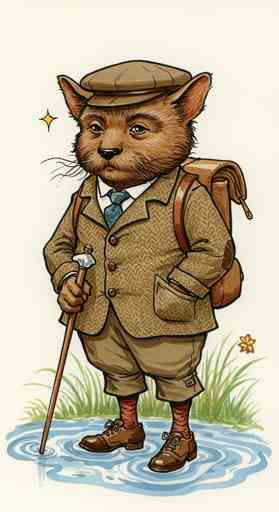

### Badger Description

A solitary, grey Badger. Gruff, suspicious voice but also shows kindness. Wears a long, perhaps slightly worn dressing-gown and down-at-heel slippers. Embody a sense of ancient wisdom and quiet strength. He has a broad glistening muzzle. His dwelling is a cozy, but shabby, place, filled with stacks of supplies. Style: Watercolor illustration, Arthur Rackham style

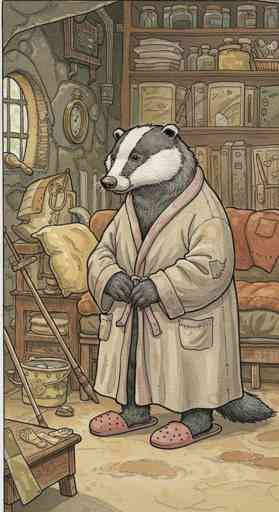

### Toad Description

A short, stout figure. Boastful and conceited, though good-natured. He can wear goggles, cap, gaiters, and an enormous overcoat, showing his love for motor-cars. Features should convey a sense of impulsiveness and a lack of stability. Emphasize his changeable nature and his tendency to become obsessed with the latest craze. Style: Watercolor illustration, Arthur Rackham style

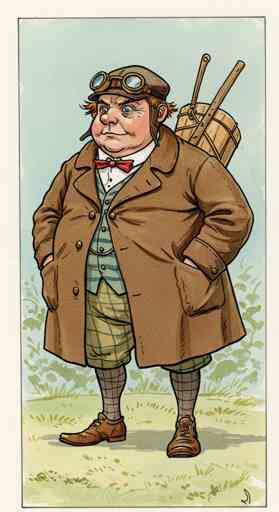

In [14]:
import io
from PIL import Image
from IPython.display import display

for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for image_generated in image_generated.generated_images:
      image_bytes = image_generated.image.image_bytes
      with io.BytesIO(image_bytes) as f:
          im = Image.open(f)
          im.thumbnail((512, 512))
          im.save("temp.jpg", "JPEG", quality=30)
      with open("temp.jpg", "rb") as f:
          display(Image.open(f))









## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [15]:
response = chat.send_message("Now, for each chapters of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Be very descriptive and remember to reuse the character prompts if they appear in the images. Each character should at least be described with 30 words.")

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter I: The River Bank",
        "prompt": "A Mole, covered in splashes of whitewash over his black fur, emerges from a steep little tunnel into a great meadow, flinging down his brush. He stands next to the full-fed river. The Water Rat, a brown little face with whiskers, a grave round face with a twinkle in its eye, small neat ears, and thick silky hair, peeks from a dark hole in the bank opposite, just above the water\u2019s edge, looking cautiously at the Mole. The Rat is wearing smart but practical river attire. Style: Watercolor illustration, Arthur Rackham style"
    },
    {
        "name": "Chapter II: The Open Road",
        "prompt": "The good-natured Water Rat, brown fur glistening in the sun, sits on the river bank. He is dressed practically, but smartly. He has a twinkle in his eye. The Mole, eager and excited, stands beside a gipsy caravan, painted a canary-yellow picked out with green, and red wheels. Toad, a short stout figure, in riding out

### Chapter I: The River Bank

A Mole, covered in splashes of whitewash over his black fur, emerges from a steep little tunnel into a great meadow, flinging down his brush. He stands next to the full-fed river. The Water Rat, a brown little face with whiskers, a grave round face with a twinkle in its eye, small neat ears, and thick silky hair, peeks from a dark hole in the bank opposite, just above the water’s edge, looking cautiously at the Mole. The Rat is wearing smart but practical river attire. Style: Watercolor illustration, Arthur Rackham style

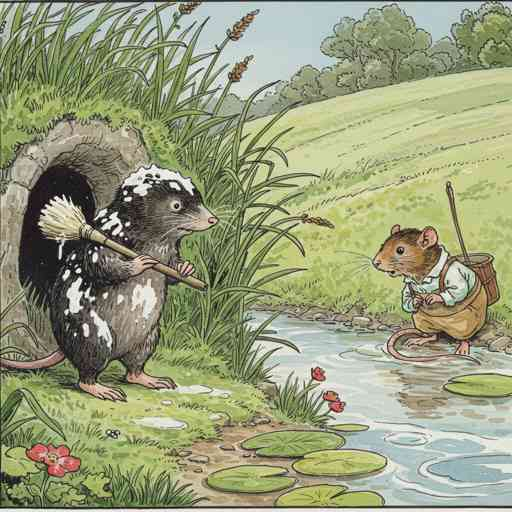

### Chapter II: The Open Road

The good-natured Water Rat, brown fur glistening in the sun, sits on the river bank. He is dressed practically, but smartly. He has a twinkle in his eye. The Mole, eager and excited, stands beside a gipsy caravan, painted a canary-yellow picked out with green, and red wheels. Toad, a short stout figure, in riding outfit, a large map spread out on his knees, struts nearby, expanding himself. Style: Watercolor illustration, Arthur Rackham style

### Chapter III: The Wild Wood

A Mole, small and vulnerable, runs in panic through the Wild Wood. The trees crouch nearer and nearer, holes make ugly mouths at him on either side with little evil wedge-shaped faces, looking out at him. The valiant Water Rat, with brown fur, a brace of pistols in his belt, and a great ugly cudgel in his grasp, searches anxiously, looking on either side, calling, ‘Moly, Moly, Moly!’. Style: Watercolor illustration, Arthur Rackham style

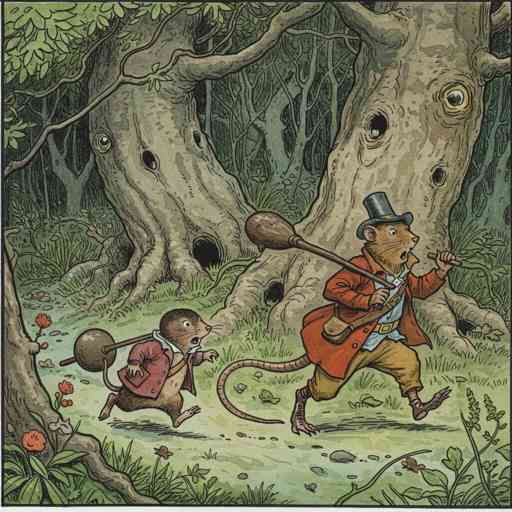

In [16]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  if image_generated.generated_images is not None:
    for image_generated in image_generated.generated_images:
      image_bytes = image_generated.image.image_bytes
      with io.BytesIO(image_bytes) as f:
          im = Image.open(f)
          im.thumbnail((512, 512))
          im.save("temp.jpg", "JPEG", quality=30)
      with open("temp.jpg", "rb") as f:
          display(Image.open(f))

# With an Audiobook: The Adventures of Chatterer the Red Squirrel

This time, you are going to use an audiobook as the source, and in this case *The Adventures of Chatterer the Red Squirrel* audiobook from the open-source library [Librivox](https://librivox.org/the-adventures-of-chatterer-the-red-squirel-by-thornton-w-burgess/).

## 1/ Get the audiobook and merge its chapters
You could upload all the chapters one by one, but it's easier to merge all the chapters together befor uploading the audiobook and only deal with one file.

For the sake of the length of the demonstration, you will only merge the first 5 chapters, but feel free to update the code and try on the full book.

In [17]:
%pip install pydub
import os
import zipfile
from pydub import AudioSegment

# Download the zip file
!wget https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip

# Unzip the file
with zipfile.ZipFile("chatterertheredsquirrel_1307_librivox_64kb_mp3.zip", 'r') as zip_ref:
    zip_ref.extractall("audiobook")

# Get a list of all MP3 files in the extracted folder
mp3_files = [f for f in os.listdir("audiobook") if f.endswith('.mp3')]

mp3_files.sort()

if len(mp3_files) > 1:
    combined_audio = AudioSegment.empty()
    for i in range(min(5, len(mp3_files))):  # Limit to 5 or fewer chapters
        mp3_file = mp3_files[i]  # Get the filename using the index
        combined_audio += AudioSegment.from_mp3(os.path.join("audiobook", mp3_file))
    combined_audio.export("audiobook.mp3", format="mp3")
    print("MP3 files merged into audiobook.mp3")
else:
    print("Only one MP3 file found, no merging needed.")

--2025-03-12 14:37:09--  https://www.archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving www.archive.org (www.archive.org)... 207.241.224.2
Connecting to www.archive.org (www.archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-03-12 14:37:09--  https://archive.org/download/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia600105.us.archive.org/12/items/chatterertheredsquirrel_1307_librivox/chatterertheredsquirrel_1307_librivox_64kb_mp3.zip [following]
--2025-03-12 14:37:09--  https://ia600

Now upload it using the File API:

In [18]:
audiobook = client.files.upload(file="audiobook.mp3")

## 2/ Start the chat

Oonce again, using [chat mode](https://ai.google.dev/gemini-api/docs/text-generation?lang=python#chat) here let Gemini will keep the history of what you asked it, and also so that you don't have to send it the book every time.

[Structured output](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) is used to force Gemini to output nice lists of prompts.

In [19]:
from pydantic import BaseModel

class Prompts(BaseModel):
    name: str
    prompt: str


In [20]:
# Re-run this cell if you want to start anew.
chat = client.chats.create(
    model=gemini_model_name,
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=list[Prompts],
    ),
)

chat.send_message(["Here's an audiobook, to illustrate using Imagen. Don't say anything for now, instructions will follow.",audiobook]);

## 3/ Define a style

If you want to test a specific style, just write it down and Gemini will use it. Still, tell Gemini about it so it will adapt the prompts it will generate accordingly. That's what is illustrated here with a futuristic style.

If you prefer to let Gemini choose the best style for the book, leave the style empty and ask Gemini to define a style fitting to the book.

In [21]:
style = "futuristic, science fiction, utopia, saturated, neon lights" # @param {type:"string", "placeholder":"Write your own style or leave empty to let Gemini generate one"}

if style == "":
  response = chat.send_message("Can you define a art style that would fit the story? Just give us the prompt for the art syle that will added to the furture prompts.")
  style = json.loads(response.text)[0]["prompt"]
else:
  chat.send_message(f'The art style will be:"{style}". Keep that in mind when generating future prompts. Keep quiet for now, instructions will follow.')

display(Markdown(f"### Style:"))
print(style)

style = f'Follow this style: "{style}" '

### Style:

futuristic, science fiction, utopia, saturated, neon lights


In [22]:
system_instructions = """
  There must be no text on the image, it should not look like a cover page.
  It should be an full illustration with no borders, titles, nor description.
  Stay family-friendly with uplifting colors.
"""

## 4/ Generate portraits of the main characters

You are now ready to start generating images, starting with the main characters.

In [23]:
response = chat.send_message(["Can you describe the main characters and prepare a prompt describing them with as much details as possible (use the descriptions from the book) so Imagen can generate images of them?"])

characters = json.loads(response.text)

print(json.dumps(characters, indent=4))

[
    {
        "name": "Chatterer the Red Squirrel",
        "prompt": "Chatterer is the protagonist of this futuristic adventure. He is a small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance."
    },
    {
        "name": "Shadow the Weasel",
        "prompt": "Shadow is Chatterer's relentless pursuer. He is depicted as a slim, shadowy figure with glowing red eyes that reveal a hunger and anger. Shadow is so slim that he can slip in and out of places that even Chatterer cannot get through. His appearance should be sleek and almost serpentine, reflecting his ability to squeeze i

### Chatterer the Red Squirrel

Chatterer is the protagonist of this futuristic adventure. He is a small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance.

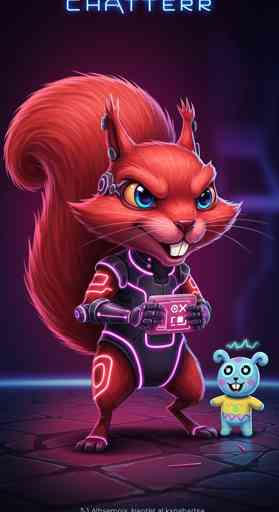

### Shadow the Weasel

Shadow is Chatterer's relentless pursuer. He is depicted as a slim, shadowy figure with glowing red eyes that reveal a hunger and anger. Shadow is so slim that he can slip in and out of places that even Chatterer cannot get through. His appearance should be sleek and almost serpentine, reflecting his ability to squeeze into tight spaces. Shadow embodies a sense of inescapable danger, his presence constantly looming over Chatterer's every move. A menacing figure with a technological twist.

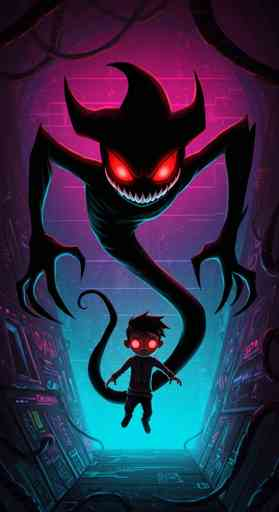

### Peter Rabbit

Peter is a friend of Chatterer's who lives by the old stone wall in Farmer Brown's cornfield. He is a sleek, futuristic rabbit known for his long legs and ability to run fast. Peter is depicted as somewhat naive but always helpful, offering advice and companionship to Chatterer in his time of need. This can be conveyed through a kind expression and a watchful stance, ready to dart away at a moment's notice.

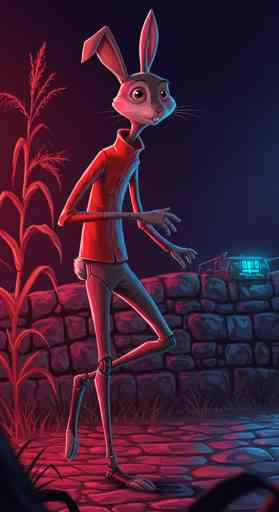

In [24]:
for character in characters[:max_character_images]:
  display(Markdown(f"### {character['name']}"))
  display(Markdown(character['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=character['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="9:16"
      )
  )

  if image_generated.generated_images is not None:
    for image_generated in image_generated.generated_images:
      image_bytes = image_generated.image.image_bytes
      with io.BytesIO(image_bytes) as f:
          im = Image.open(f)
          im.thumbnail((512, 512))
          im.save("temp.jpg", "JPEG", quality=30)
      with open("temp.jpg", "rb") as f:
          display(Image.open(f))

## 5/ Illustrate the chapters of the book

After the characters, it's now time to create illustrations for the content of the book. You are going to ask Gemini to generate prompts for each chapter and then ask Imagen to generate images based on those prompts.

In [25]:
response = chat.send_message(["Now, for each chapter of the book, give me a prompt to illustrate what happens in it. Be very descriptive, especially of the characters. Remember to reuse the character prompts if they appear in the image"])

chapters = json.loads(response.text)[:max_chapter_images]

print(json.dumps(chapters, indent=4))

[
    {
        "name": "Chapter 1",
        "prompt": "A futuristic, science fiction setting bathed in saturated neon lights. \"Chatterer the Red Squirrel\" (A small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance.) is running for his life through a neon-lit cityscape. He is fleeing from \"Shadow the Weasel\" (a slim, shadowy figure with glowing red eyes that reveal a hunger and anger. Shadow is so slim that he can slip in and out of places that even Chatterer cannot get through. His appearance should be sleek and almost serpentine, reflecting his ability to squeeze into tight sp

### Chapter 1

A futuristic, science fiction setting bathed in saturated neon lights. "Chatterer the Red Squirrel" (A small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance.) is running for his life through a neon-lit cityscape. He is fleeing from "Shadow the Weasel" (a slim, shadowy figure with glowing red eyes that reveal a hunger and anger. Shadow is so slim that he can slip in and out of places that even Chatterer cannot get through. His appearance should be sleek and almost serpentine, reflecting his ability to squeeze into tight spaces. Shadow embodies a sense of inescapable danger, his presence constantly looming over Chatterer's every move. A menacing figure with a technological twist.) , a shadowy figure with glowing red eyes, as "Bobby Coon", now a cyborg-like creature, watches in the background. The overall scene should emphasize speed, danger, and a sense of desperation within this utopian-turned-dystopian environment.

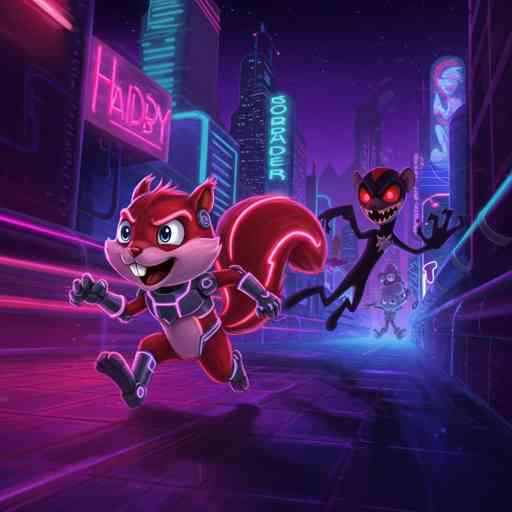

### Chapter 2

High atop a bioluminescent, towering chestnut tree, "Chatterer the Red Squirrel" (A small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance.) is pulling one of Redtail's feathers. "Old Redtail the Hawk" (is a large, imposing hawk who is one of Chatterer's deadliest enemies. He is known for dozing near the top of tall trees and has no preference between Chatterer and Shadow, the Weasel. He is easily angered, and should be a huge hawk with angry features.) is a massive cybernetic hawk, perched on a branch amidst the utopian architecture. "Shadow the Weasel" (a slim, shadowy figure with glowing red eyes that reveal a hunger and anger. Shadow is so slim that he can slip in and out of places that even Chatterer cannot get through. His appearance should be sleek and almost serpentine, reflecting his ability to squeeze into tight spaces. Shadow embodies a sense of inescapable danger, his presence constantly looming over Chatterer's every move. A menacing figure with a technological twist.) is in mid-air, about to be swooped upon by Redtail, with sparks flying from Redtail's mechanical talons. The overall image should be a blend of nature and technology, danger and beauty, set in a futuristic, neon-saturated landscape.

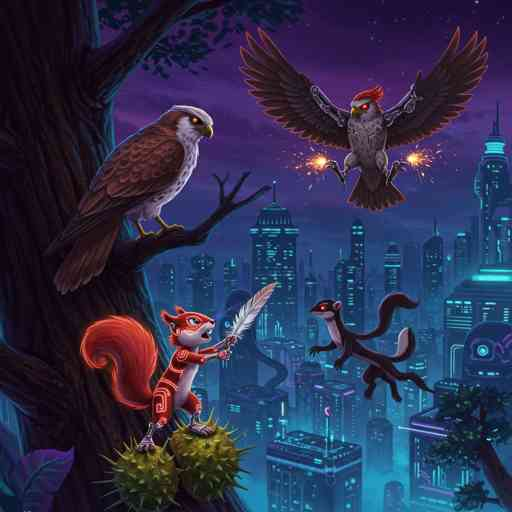

### Chapter 3

"Sammy Jay" (known to have a very distinctive loud voice, well-known throughout the green forest. Sammy Jay, though mean-spirited, has a caring side deep down. Sammy Jay should have very loud and piercing eyes.) now depicted as a holographic messenger, broadcasts an urgent message across the neon-lit Green Forest. The forest is a technologically advanced habitat with glowing plants and floating platforms. "Chatterer the Red Squirrel" (A small red squirrel, with glowing fur and sleek, mechanical enhancements. He is mean, impetuous, and constantly stirring up trouble with his unruly tongue. His distinctive red fur coat is adorned with neon accents, and his eyes have a mischievous, cunning glint. Although often boastful and quick to quarrel, he is also capable of remorse and a desire to do what is right, as evidenced by his concern for Happy Jack. This duality should be reflected in his appearance.) asks Sammy Jay for help in a scene emphasizing communication networks, technological dissemination of information, and a blend of organic and synthetic elements.

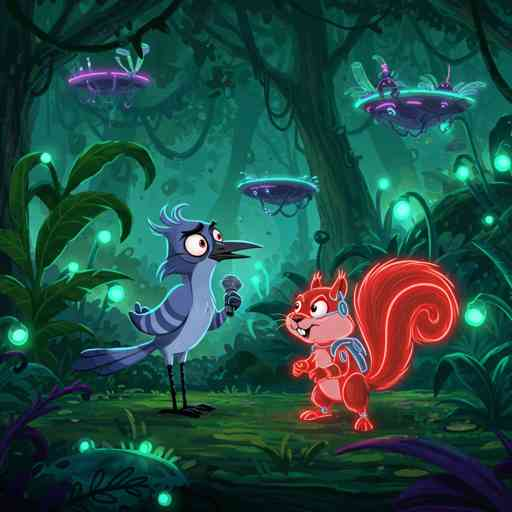

In [26]:
for chapter in chapters:
  display(Markdown(f"### {chapter['name']}"))
  display(Markdown(chapter['prompt']))

  image_generated = client.models.generate_images(
      model=imagen_model_name,
      prompt=chapter['prompt'] + style + system_instructions,
      config=types.GenerateImagesConfig(
          number_of_images=1,
          output_mime_type="image/jpeg",
          safety_filter_level="BLOCK_LOW_AND_ABOVE",
          person_generation="ALLOW_ADULT",
          aspect_ratio="1:1"
      )
  )

  if image_generated.generated_images is not None:
    for image_generated in image_generated.generated_images:
      image_bytes = image_generated.image.image_bytes
      with io.BytesIO(image_bytes) as f:
          im = Image.open(f)
          im.thumbnail((512, 512))
          im.save("temp.jpg", "JPEG", quality=30)
      with open("temp.jpg", "rb") as f:
          display(Image.open(f))

# Next Steps
### Useful documentation references:

To improve your prompting skills, check the [prompt guide](https://ai.google.dev/gemini-api/docs/imagen-prompt-guide) for great advices on creating your prompts.

### Related examples

If you're curious about cool things you can build with Imagen, check those great examples:
* [Zoom on earth](../examples/Zoom_on_earth.ipynb): Another take on mixing Gemini and Imagen, this time using [function calling](./Function_calling.ipynb) to communicate.
* [Generative designs](../examples/Generative_designs.ipynb): This time Gemini will ingest a bunch of images to serve as models to generate model designs.

### Continue your discovery of the Gemini API

Gemini is not only good at generating images, but also at understanding them. Check the [Spatial understanding](./Spatial_understanding.ipynb) guide for an introduction on those capabilities, and the [Video understanding](./Video_understanding.ipynb) one for video examples.

You should also have a look at the [Live API](../quickstarts/Get_started_LiveAPI.ipynb) to create live intereactions with the models.
